In [1]:
import numpy as np, pandas as pd, time, os, itertools, subprocess, scipy as sp, re
import seaborn; seaborn.set_style('whitegrid')
import matplotlib.pyplot as plt, importlib
import scipy.sparse
import utils, diffmap as dm#, scanpy as sc
import sklearn.metrics

data_pfx = '/oak/stanford/groups/akundaje/abalsubr/search_ui/'

In [38]:
importlib.reload(utils)
experiments_core = pd.DataFrame.from_csv("data/ENCODE2018Core.tsv", index_col=None, sep='\t')
experiments_sparse = pd.DataFrame.from_csv("data/ENCODE2018Sparse.tsv", index_col=None, sep='\t')
experiments_sparse = experiments_sparse.rename(columns={"Accession_x": "Accession"})
experiments = pd.concat((experiments_core, experiments_sparse))

/users/abalsubr/anaconda2/envs/scs3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
/users/abalsubr/anaconda2/envs/scs3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


# Experimental embeddings

In [6]:
itime = time.time()
eemb = np.load(data_pfx + 'avocado_model/experiment_embedding.npz')['arr_0']
print(time.time() - itime)
sparse_adj = utils.make_nn_graph(eemb, k=10)
print(time.time() - itime)

0.1419386863708496
5.411322832107544


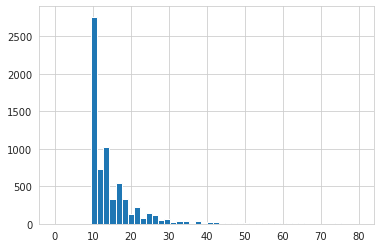

In [9]:
#scipy.sparse.save_npz(data_pfx + 'encode3_6870_10nn.npz', sparse_adj)
plt.hist(np.ravel(sparse_adj.sum(axis=0)), bins=50, range=(0,80))
plt.show()

In [45]:
from umap import UMAP
itime = time.time()
X_umap = UMAP(200, random_state=111).fit_transform(eemb)
print(time.time() - itime)

/users/abalsubr/anaconda2/envs/scs3/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../anaconda2/envs/scs3/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


66.47995853424072


In [49]:
experiments['umap_raw_X'] = X_umap[:,0]
experiments['umap_raw_Y'] = X_umap[:,1]

In [52]:
itime = time.time()
X_diffmap_100 = dm.diffmap_proj(sparse_adj, n_dims=100)
print(time.time() - itime)

101 dimensions contain about 0.95 fraction of the variance in the first 2000 dimensions (Diffusion time = 19.126298161980007)
310.04082918167114


In [53]:
itime = time.time()
X_umap_2 = UMAP(200, random_state=111).fit_transform(X_diffmap_100)
print(time.time() - itime)
experiments['umap_graph_X'] = X_umap_2[:,0]
experiments['umap_graph_Y'] = X_umap_2[:,1]

/users/abalsubr/anaconda2/envs/scs3/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../anaconda2/envs/scs3/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


54.893067359924316


In [57]:
experiments.to_csv('data/experiments.csv', sep='\t', index=None)